In [45]:
# IMPORTS
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from matplotlib import pyplot as plt
import os
import time

In [46]:
# Générateur pour l'ensemble d'entraînement
train_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Générateur pour l'ensemble de validation
valid_gen = ImageDataGenerator(rescale=1.0/255)

# Chargement des données d'entraînement
train_data = train_gen.flow_from_directory(
    "dataset/train/",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical"
)

# Chargement des données de validation
val_data = valid_gen.flow_from_directory(
    "dataset/valid/",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical"
)

categories = list(train_data.class_indices.keys())  # Extraire les catégories
print("Catégories :", categories)


Found 1084 images belonging to 5 classes.
Found 704 images belonging to 5 classes.
Catégories : ['car', 'cats', 'dogs', 'flowers', 'none']


In [47]:
# Définition du nombre d'itérations nécessaires pour parcourir l'intégralité de notre jeu de données lors d'une époque.
# Pour phase d'entrainement
steps_train = train_data.samples // train_data.batch_size

In [48]:
# Définition du nombre d'itérations nécessaires pour parcourir l'intégralité de notre jeu de données lors d'une époque.
# Pour phase de test
steps_valid = val_data.samples // val_data.batch_size

In [49]:
print(f"Nombre total d'images dans le train set : {train_data.samples}")
print(f"Nombre total d'images dans le valid set : {val_data.samples}")


Nombre total d'images dans le train set : 1084
Nombre total d'images dans le valid set : 704


In [50]:
cls_train = train_data.classes
cls_test =  val_data.classes
class_names = list(val_data.class_indices.keys())
class_names

['car', 'cats', 'dogs', 'flowers', 'none']

In [51]:
def path_join(dirname, filenames):
    # Joindre les noms de fichiers au chemin du répertoire
    return [os.path.join(dirname, filename) for filename in filenames]

image_paths_train = path_join("dataset/train/", train_data.filenames)
image_paths_test = path_join("dataset/valid/", val_data.filenames)

def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true)

    # Créer une figure avec des sous-graphiques (sub-plots).
    fig, axes = plt.subplots(3, 3)

    # Ajuster l'espacement vertical.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Type d'interpolation.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # Il peut y avoir moins de 9 images, s'assurer que cela ne plante pas.
        if i < len(images):
            # Afficher l'image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Nom de la classe vraie.
            cls_true_name = class_names[cls_true[i]]

            # Afficher les classes vraies et prédites.
            if cls_pred is None:
                xlabel = "Vrai : {0}".format(cls_true_name)
            else:
                # Nom de la classe prédite.
                cls_pred_name = class_names[cls_pred[i]]
                xlabel = "Vrai : {0}\nPrédit : {1}".format(cls_true_name, cls_pred_name)
            # Afficher les classes comme étiquette sur l'axe des x.
            ax.set_xlabel(xlabel)
        # Supprimer les ticks du graphique.
        ax.set_xticks([])
        ax.set_yticks([])

    # Assurer que le graphique est bien affiché avec plusieurs graphiques
    # dans une seule cellule de Notebook.
    plt.show()

def load_images_custom(image_paths):
    # Charger les images depuis le disque.
    images = [plt.imread(path) for path in image_paths]
    # Convertir en tableau numpy et le retourner.
    return np.asarray(images)

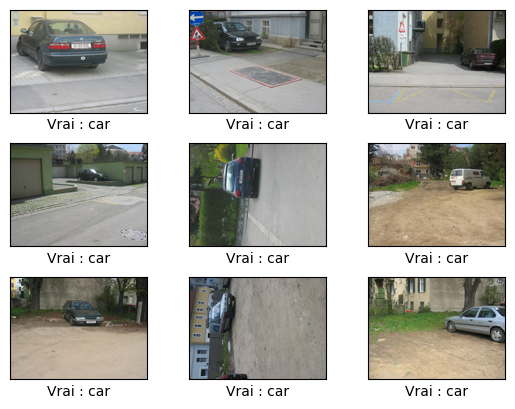

In [52]:
# Charger les premières images de l'ensemble d'entraînement.
images = load_images_custom(image_paths=image_paths_train[0:9])

# Obtenir les classes vraies pour ces images.
cls_true = cls_train[0:9]

# Afficher les images et les étiquettes en utilisant notre fonction d'aide ci-dessus.
plot_images(images=images, cls_true=cls_true, smooth=True)

In [53]:
# Définition d'un modèle CNN simple
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')  # Une sortie par catégorie
])

# Compilation du modèle
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Résumé du modèle
model.summary()

/Users/atsug0/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300


/Users/atsug0/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.2681 - loss: 1.6674 - val_accuracy: 0.3352 - val_loss: 1.4269
Epoch 2/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.3578 - loss: 1.4273 - val_accuracy: 0.4006 - val_loss: 1.3853
Epoch 3/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.4218 - loss: 1.2890 - val_accuracy: 0.5384 - val_loss: 1.1839
Epoch 4/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.4504 - loss: 1.2721 - val_accuracy: 0.5909 - val_loss: 1.1409
Epoch 5/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.5055 - loss: 1.1991 - val_accuracy: 0.5710 - val_loss: 1.1634
Epoch 6/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.5473 - loss: 1.0644 - val_accuracy: 0.6463 - val_loss: 0.9769
Epoch 7/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.5608 - loss: 1.0259 - val_accuracy: 0.6776 - val_loss: 0.7957
Epoch 8/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.6157 - loss: 0.9618 - val_accuracy: 0.6889

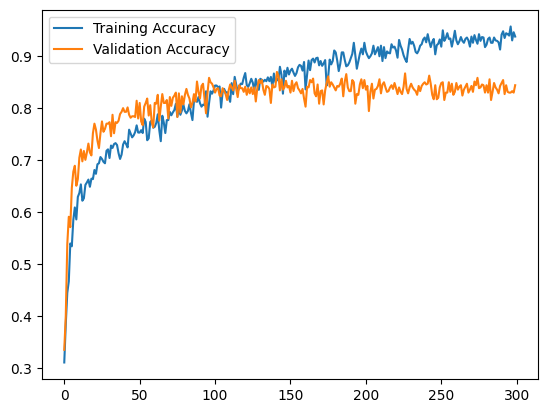

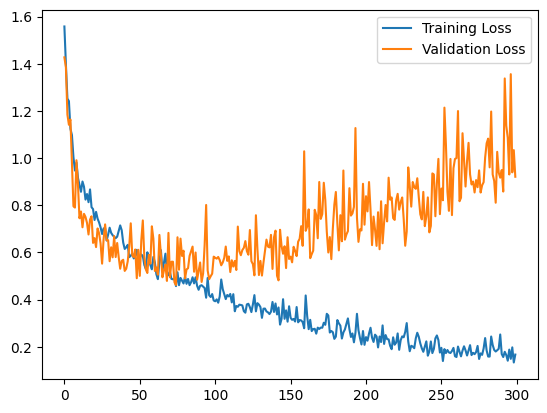

Le modèle a été entraîné en 2877.92 secondes.


In [54]:
# Callbacks
start = time.time()

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=300,  # Ajustez selon vos besoins
    verbose=1
)

# Tracer les courbes d'entraînement et de validation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


end = time.time()

print(f"Le modèle a été entraîné en {end - start:.2f} secondes.")


In [66]:
end = time.time()

print ("Model took %0.2f seconds to train"%(end - start))
result = model.evaluate(val_data, steps=1)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))


Model took 2960.13 seconds to train
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9062 - loss: 0.2724
Test-set classification accuracy: 90.62%


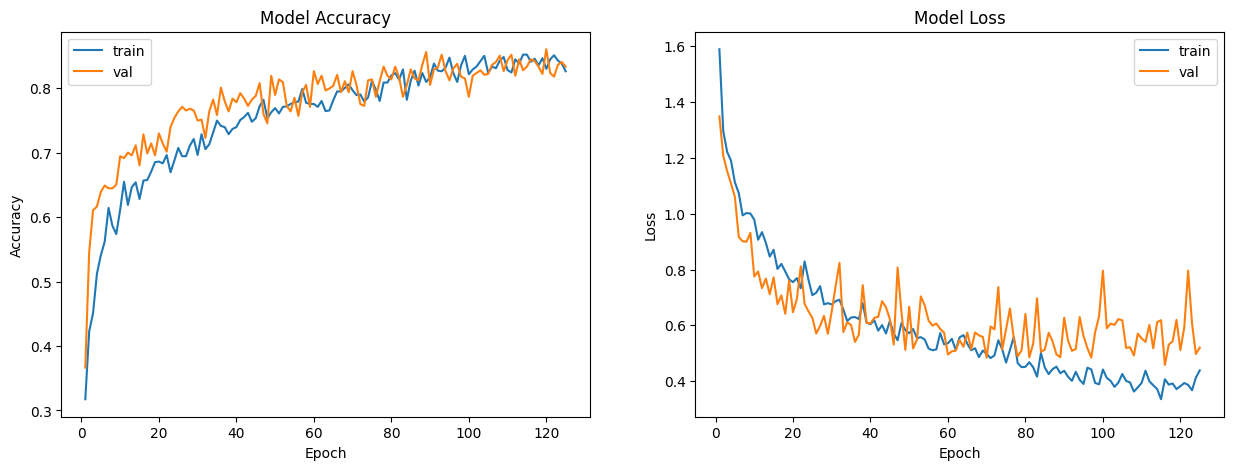

In [30]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(history)

In [31]:
def predict_image(image_path, target_category, threshold=0.5):
    """
    Vérifie si une image appartient à une catégorie spécifique.

    :param image_path: Chemin de l'image
    :param target_category: Catégorie à vérifier (ex: "Dog")
    :param threshold: Seuil de confiance minimal (entre 0 et 1)
    :return: (Booléen, catégorie prédite, confiance)
    """
    # Charger et prétraiter l'image
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0  # Normaliser entre 0 et 1
    img_array = np.expand_dims(img_array, axis=0)

    # Faire la prédiction
    predictions = model.predict(img_array)
    class_index = np.argmax(predictions)
    confidence = predictions[0][class_index]  # Confiance pour la classe prédite
    predicted_category = categories[class_index]

    return (predicted_category == target_category) and (confidence >= threshold), predicted_category, confidence


In [32]:
image_path = "dataset/train/dogs/dog_76.jpg"
target_category = "car"  # Exemple de catégorie

is_match, predicted_category, confidence = predict_image(image_path, target_category, threshold=0.6)

if is_match:
    print(f"L'image est un(e) {target_category} avec une confiance de {confidence:.2f}.")
else:
    print(f"L'image n'est pas un(e) {target_category}. Elle est probablement un(e) {predicted_category} avec une confiance de {confidence:.2f}.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
L'image n'est pas un(e) car. Elle est probablement un(e) dogs avec une confiance de 0.78.


In [67]:
# Sauvegarder le modèle
model.save("cnn_multipleReconnection_model.h5")

# Charger le modèle
#from tensorflow.keras.models import load_model
#model = load_model("cnn_multipleReconnection_model.h5")